# Dairy Goods Sales and Sales Forecasting using PySpark and Tableau

In [1]:
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-1.8"
os.environ["SPARK_HOME"] = "C:\\apps\\opt\\spark-3.4.1-bin-hadoop3"

# importing required libraries 

Installing PySpark

In [2]:
#!pip install pyspark

importing required modules

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, RandomForestRegressor,GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, sum, to_date
from pyspark.sql.types import DateType
from pyspark.sql import functions as F
from pyspark.sql.functions import dayofweek
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import year, month, dayofmonth, lit, when
from pyspark.sql.functions import col, concat, lit, concat_ws
from pyspark.sql.functions import sum
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate
from pyspark.ml import Pipeline
import calendar

Initializing a Spark session

In [4]:
spark = SparkSession.builder.appName("DairySalesPrediction").getOrCreate()

Loading the Dairy Good Sales dataset

In [5]:
data_path = "dairy_dataset_main.csv"

Storing the loaded data in the DataFrame

In [6]:
data_df=spark.read.csv(data_path, header=True, inferSchema=True)

# Data Preprocessing

 Identifying the number of rows and Columns in the data

In [7]:
num_rows = data_df.count()
num_cols = len(data_df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 4325
Number of columns: 23


Displaying the features and their data types

In [8]:
data_df.printSchema()

root
 |-- Location: string (nullable = true)
 |-- Total Land Area (acres): double (nullable = true)
 |-- Number of Cows: integer (nullable = true)
 |-- Farm Size: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Product ID: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Quantity (liters/kg): double (nullable = true)
 |-- Price per Unit: double (nullable = true)
 |-- Total Value: double (nullable = true)
 |-- Shelf Life (days): integer (nullable = true)
 |-- Storage Condition: string (nullable = true)
 |-- Production Date: date (nullable = true)
 |-- Expiration Date: date (nullable = true)
 |-- Quantity Sold (liters/kg): integer (nullable = true)
 |-- Price per Unit (sold): double (nullable = true)
 |-- Approx. Total Revenue(INR): double (nullable = true)
 |-- Customer Location: string (nullable = true)
 |-- Sales Channel: string (nullable = true)
 |-- Quantity in Stock (liters/kg): integer (nullable = true)

In [9]:
column_data = [(col_name, col_type) for col_name, col_type in data_df.dtypes]

print(tabulate(column_data, headers=["Column Name", "Data Type"], tablefmt="grid"))

+-------------------------------------+-------------+
| Column Name                         | Data Type   |
+=====================================+=============+
| Location                            | string      |
+-------------------------------------+-------------+
| Total Land Area (acres)             | double      |
+-------------------------------------+-------------+
| Number of Cows                      | int         |
+-------------------------------------+-------------+
| Farm Size                           | string      |
+-------------------------------------+-------------+
| Date                                | date        |
+-------------------------------------+-------------+
| Product ID                          | int         |
+-------------------------------------+-------------+
| Product Name                        | string      |
+-------------------------------------+-------------+
| Brand                               | string      |
+---------------------------

Displaying records in the DataFrame 

In [10]:
data_df.toPandas()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,2022-02-16,2022-02-21,352,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,2022-03-22,2022-04-14,68,58.39,3970.52,Kerala,Retail,750,87.41,114.37
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,2020-01-04,2020-01-11,141,89.46,12613.86,Haryana,Retail,442,33.47,153.66
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,2022-10-02,2022-10-09,2,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84


# Data Cleaning


Renaming Column Names

In [11]:
data_df = data_df.withColumnRenamed('Approx. Total Revenue(INR)','Approx_Total_Revenue_INR')

Checking for missing values

In [12]:
missing_columns = [col_name for col_name in data_df.columns if data_df.filter(data_df[col_name].isNull()).count() > 0]

Handling missing values if necessary Fill missing values with "N/A" or  Droping rows with missing values

In [13]:
if missing_columns:
    fill_value = "N/A"
    for col_name in missing_columns:
        data_df = data_df.withColumn(col_name, when(data_df[col_name].isNull(), fill_value).otherwise(data_df[col_name]))
    data_df = data_df.dropna(subset=missing_columns)

if len(missing_columns) == 0:
    print("No missing values found.")
else:
    print("There are missing values.")


No missing values found.


Evaluating missing data count

In [14]:
missing_data_counts = data_df.agg(*[sum(data_df[c].isNull().cast("int")).alias(c) for c in data_df.columns])
missing_data_counts.toPandas()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx_Total_Revenue_INR,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Missing Value Heatmap

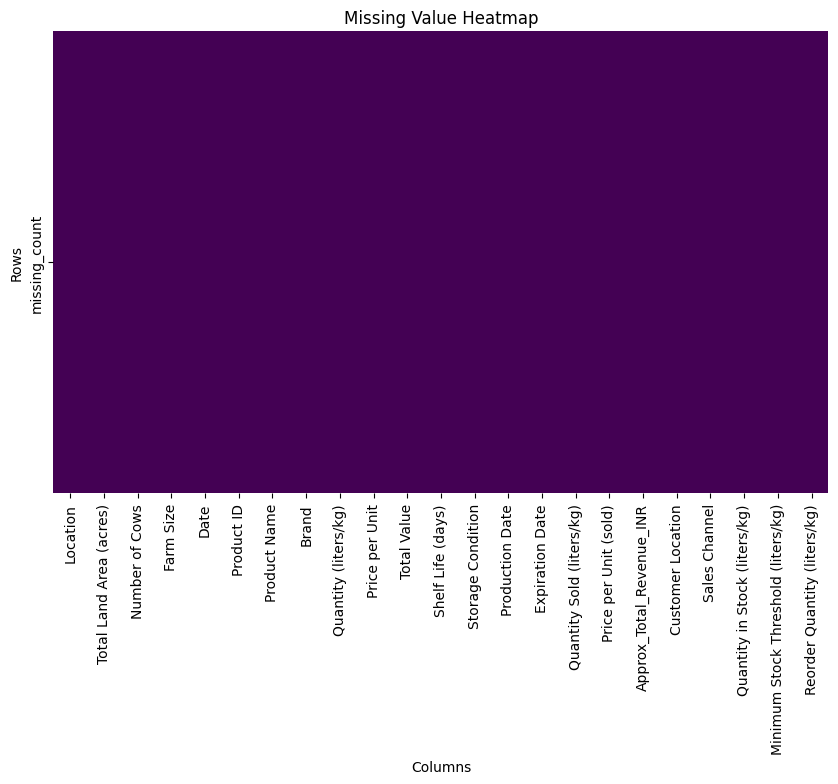

In [15]:
missing_data_counts = data_df.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data_df.columns])

missing_data_pd = missing_data_counts.toPandas().transpose()
missing_data_pd.columns = ['missing_count']

# Creating a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data_pd.transpose().isna(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

Checking Duplicate values

In [16]:
def check_duplicate(df):
    if df.dropDuplicates().count() == df.count():
        return 'Data Is clean, No Duplicate Data Found.'
    else:
        return 'There are duplicate Data in DataFrame, Needed To Be Removed.'

result = check_duplicate(data_df)

print(result)

Data Is clean, No Duplicate Data Found.


We have checked for the duplicate values and also checked the rows with missing or undefined values in numerical calculations. But in the given dataset, there are no missing values or duplicate values. Hence there is no row or column to be dropped or replaces with other values.

Coverting date Columns to proper date format

In [17]:
date_columns = ['Date', 'Production Date', 'Expiration Date']

for col in date_columns:
    data_df = data_df.withColumn(col, to_date(col, 'yyyy-MM-dd').cast(DateType()))

In [18]:
data_df.toPandas()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx_Total_Revenue_INR,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,2022-02-16,2022-02-21,352,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,2022-03-22,2022-04-14,68,58.39,3970.52,Kerala,Retail,750,87.41,114.37
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,2020-01-04,2020-01-11,141,89.46,12613.86,Haryana,Retail,442,33.47,153.66
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,2022-10-02,2022-10-09,2,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84


Saving the cleaned dataset in a  new csv file

In [19]:
data_df.toPandas().to_csv("dairy_dataset.csv", index=False)

# SPARK SQL

In [20]:
data_df.createOrReplaceTempView("sales_data_view")

In [21]:
result = spark.sql("SELECT * FROM sales_data_view")

result.toPandas()


,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx_Total_Revenue_INR,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,2022-02-16,2022-02-21,352,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,2022-03-22,2022-04-14,68,58.39,3970.52,Kerala,Retail,750,87.41,114.37
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,2020-01-04,2020-01-11,141,89.46,12613.86,Haryana,Retail,442,33.47,153.66
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,2022-10-02,2022-10-09,2,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84


# Feature Selection  

Feature Columns for analysis

In [22]:
feature_columns = ['Customer Location', 'Sales Channel', 'Product ID', 'Quantity (liters/kg)', 'Price per Unit (sold)',  'Approx_Total_Revenue_INR','Date', 'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)']
target_column = 'Quantity Sold (liters/kg)'

# Feature Engineerig

Extracting Year,Month,Day from Date column

In [23]:
data_df = data_df.withColumn("Year", F.year("date")) \
                 .withColumn("Month", F.month("date")) \
                 .withColumn("Day", F.dayofmonth("date"))

data_df.toPandas()


,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Price per Unit (sold),Approx_Total_Revenue_INR,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Year,Month,Day
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03,2022,2,17
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10,2021,12,1
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83,2022,2,28
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,28.92,17380.92,Rajasthan,Online,222,74.50,57.68,2019,6,9
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40,2020,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53,2022,2,24
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,58.39,3970.52,Kerala,Retail,750,87.41,114.37,2022,5,14
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,89.46,12613.86,Haryana,Retail,442,33.47,153.66,2020,1,5
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84,2022,10,25


In [24]:
data_df.select("Month").distinct().show()

+-----+
|Month|
+-----+
|   12|
|    1|
|    6|
|    3|
|    5|
|    9|
|    4|
|    8|
|    7|
|   10|
|   11|
|    2|
+-----+



In [25]:
# data_df = data_df.filter(col("Year")==2022)

In [26]:
data_df.select('Year').distinct().show()

+----+
|Year|
+----+
|2022|
|2019|
|2020|
|2021|
+----+



# Categorical Variable Encoding

Creating a StringIndexer for each categorical column

In [27]:
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in ['Customer Location', 'Sales Channel']]

Creating a OneHotEncoder for the indexed columns

In [28]:
encoder = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in ['Customer Location', 'Sales Channel']]

Combining indexers and encoder into a single pipeline

In [29]:
pipeline = Pipeline(stages=indexers + encoder)

Fitting and transforming the data

In [30]:
data_with_encoded = pipeline.fit(data_df).transform(data_df)

 Feature columns after feature engineering and Categorical Variable Encoding

In [31]:
feature_columns = ['Customer Location_encoded', 'Sales Channel_encoded', 'Product ID', 'Quantity (liters/kg)', 'Price per Unit (sold)',  'Approx_Total_Revenue_INR', 'Year', 'Day', 'Month', 'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)']
target_column = 'Quantity Sold (liters/kg)'

Assembling features using VectorAssembler

In [32]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(data_with_encoded)

# Model Selection

Spliting data into training and testing sets

In [33]:
train_data, test_data = data_with_features.randomSplit([0.8, 0.2], seed=42)

Initializing models

In [34]:
linear_reg = LinearRegression(labelCol=target_column, featuresCol="features")
rf_reg = RandomForestRegressor(labelCol=target_column, featuresCol="features")
gbt_reg = GBTRegressor(labelCol=target_column, featuresCol="features")

Training models

In [35]:
linear_reg_model = linear_reg.fit(train_data)
rf_reg_model = rf_reg.fit(train_data)
gbt_reg_model = gbt_reg.fit(train_data)

Making predictions

In [36]:
linear_reg_predictions = linear_reg_model.transform(test_data)
rf_reg_predictions = rf_reg_model.transform(test_data)
gbt_reg_predictions = gbt_reg_model.transform(test_data)

Evaluating Models using RMSE,MAE,R2,RMSE metrics

In [40]:
evaluator = RegressionEvaluator(labelCol=target_column, metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol=target_column, metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol=target_column, metricName="r2")
mse_evaluator = RegressionEvaluator(labelCol=target_column, metricName="mse")

Linear Regression Evaluation

In [41]:
linear_reg_rmse = evaluator.evaluate(linear_reg_predictions)
linear_reg_mse = mse_evaluator.evaluate(linear_reg_predictions)
linear_reg_mae = mae_evaluator.evaluate(linear_reg_predictions)
linear_reg_r2 = r2_evaluator.evaluate(linear_reg_predictions)

print("Linear Regression RMSE:", linear_reg_rmse)
print("Linear Regression (MSE):", linear_reg_mse)
print("Linear Regression MAE:", linear_reg_mae)
print("Linear Regression R2:", linear_reg_r2)


Linear Regression RMSE: 0.29927950772269873
Linear Regression (MSE): 0.08956822374274089
Linear Regression MAE: 0.25994561175511915
Linear Regression R2: 0.9999981314291454


Random Forest Evaluation

In [42]:
rf_reg_rmse = evaluator.evaluate(rf_reg_predictions)
rf_reg_mse = mse_evaluator.evaluate(rf_reg_predictions)
rf_reg_mae = mae_evaluator.evaluate(rf_reg_predictions)
rf_reg_r2 = r2_evaluator.evaluate(rf_reg_predictions)

print("Random Forest Regression RMSE:", rf_reg_rmse)
print("Random Forest Regression  (MSE):", rf_reg_mse)
print("Random Forest Regression MAE:", rf_reg_mae)
print("Random Forest Regression R2:", rf_reg_r2)


Random Forest Regression RMSE: 61.92252466155914
Random Forest Regression  (MSE): 3834.399060461399
Random Forest Regression MAE: 46.93600628664826
Random Forest Regression R2: 0.9200068279796759


Gradient Boosted Tree Regression Evaluation

In [43]:
gbt_reg_rmse = evaluator.evaluate(gbt_reg_predictions)
gbt_reg_mse = mse_evaluator.evaluate(gbt_reg_predictions)
gbt_reg_mae = mae_evaluator.evaluate(gbt_reg_predictions)
gbt_reg_r2 = r2_evaluator.evaluate(gbt_reg_predictions)

print("Gradient Boosted Tree Regression RMSE:", gbt_reg_rmse)
print("Gradient Boosted Tree Regression (MSE):", gbt_reg_mse)
print("Gradient Boosted Tree Regression MAE:", gbt_reg_mae)
print("Gradient Boosted Tree Regression R2:", gbt_reg_r2)

Gradient Boosted Tree Regression RMSE: 33.39012020751064
Gradient Boosted Tree Regression (MSE): 1114.9001274720104
Gradient Boosted Tree Regression MAE: 22.18319718442832
Gradient Boosted Tree Regression R2: 0.9767409713292549


Displaying metrics results of each models in a table

In [44]:
metrics = ['RMSE', 'MSE', 'MAE', 'R2']
linear_reg_metrics = [linear_reg_rmse, linear_reg_mse, linear_reg_mae, linear_reg_r2]
rf_reg_metrics = [rf_reg_rmse, rf_reg_mse, rf_reg_mae, rf_reg_r2]
gbt_reg_metrics = [gbt_reg_rmse, gbt_reg_mse, gbt_reg_mae, gbt_reg_r2]

In [45]:
model_names = ['Linear Regression', 'Random Forest Regression', 'Gradient Boosted Tree Regression']

In [46]:
table_data = []
for model, model_metrics in zip(model_names, [linear_reg_metrics, rf_reg_metrics, gbt_reg_metrics]):
    table_data.append([model] + model_metrics)

In [47]:
table = tabulate(table_data, headers=['Model'] + metrics, tablefmt='grid')

In [48]:
df = spark.createDataFrame(table_data, ['Model', *metrics]).toPandas()
df

,Model,RMSE,MSE,MAE,R2
0,Linear Regression,0.299280,0.089568,0.259946,0.999998
1,Random Forest Regression,61.922525,3834.399060,46.936006,0.920007
2,Gradient Boosted Tree Regression,33.390120,1114.900127,22.183197,0.976741


Scatter plots for each model's predicted versus actual values

Plotting Predicted vs. Actual for each model

In [49]:
linear_reg_pd = linear_reg_predictions.select(target_column, "prediction").toPandas()
rf_reg_pd = rf_reg_predictions.select(target_column, "prediction").toPandas()
gbt_reg_pd = gbt_reg_predictions.select(target_column, "prediction").toPandas()

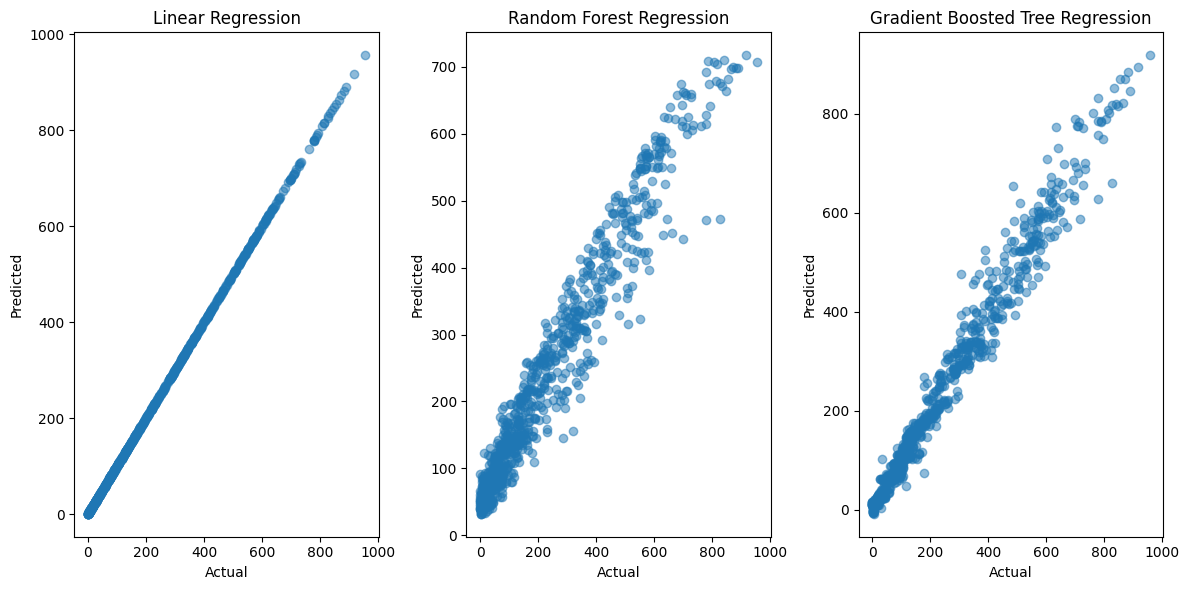

In [50]:
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.scatter(linear_reg_pd[target_column], linear_reg_pd["prediction"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression")

plt.subplot(132)
plt.scatter(rf_reg_pd[target_column], rf_reg_pd["prediction"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression")

plt.subplot(133)
plt.scatter(gbt_reg_pd[target_column], gbt_reg_pd["prediction"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Gradient Boosted Tree Regression")

plt.tight_layout()
plt.show()

Actual vs Predicted Quantity sold on a Monthly Basis

Group by year and month and sum the actual and predicted quantities

In [51]:
monthly_actual = test_data.groupBy("Month").sum("Quantity Sold (liters/kg)").withColumnRenamed("sum(Quantity Sold (liters/kg))", "Actual Quantity")
linear_reg_monthly_predictions = linear_reg_predictions.groupBy("Month").sum("prediction").withColumnRenamed("sum(prediction)", "Predicted Quantity")
rf_reg_monthly_predictions = rf_reg_predictions.groupBy("Month").sum("prediction").withColumnRenamed("sum(prediction)", "Predicted Quantity")
gbt_reg_monthly_predictions = gbt_reg_predictions.groupBy("Month").sum("prediction").withColumnRenamed("sum(prediction)", "Predicted Quantity")

monthly_actual_pd = monthly_actual.orderBy("Month").toPandas()
linear_reg_monthly_pd = linear_reg_monthly_predictions.orderBy("Month").toPandas()
rf_reg_monthly_pd = rf_reg_monthly_predictions.orderBy("Month").toPandas()
gbt_reg_monthly_pd = gbt_reg_monthly_predictions.orderBy("Month").toPandas()

In [52]:
monthly_actual_pd["Month"] = monthly_actual_pd["Month"].apply(lambda x: calendar.month_name[x])
linear_reg_monthly_pd["Month"] = linear_reg_monthly_pd["Month"].apply(lambda x: calendar.month_name[x])
rf_reg_monthly_pd["Month"] = rf_reg_monthly_pd["Month"].apply(lambda x: calendar.month_name[x])
gbt_reg_monthly_pd["Month"] = gbt_reg_monthly_pd["Month"].apply(lambda x: calendar.month_name[x])

Actual vs. Predicted Quantity Sold on a Monthly Basis (Linear Regression)

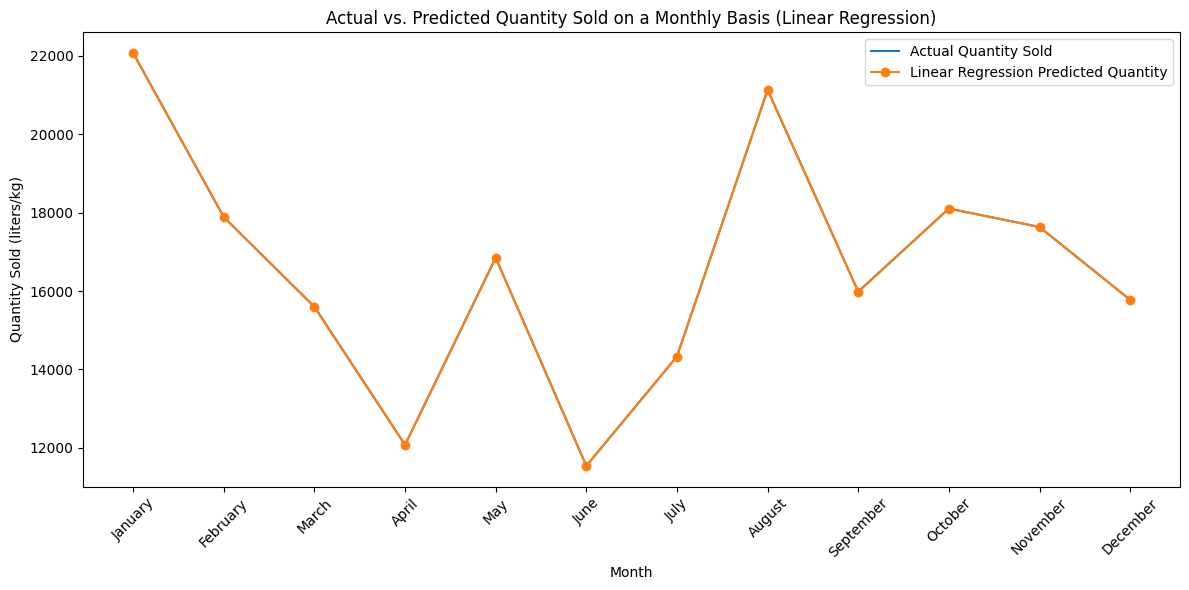

In [53]:
plt.figure(figsize=(12, 6))

plt.plot(monthly_actual_pd["Month"], monthly_actual_pd["Actual Quantity"], label='Actual Quantity Sold')
plt.plot(linear_reg_monthly_pd["Month"], linear_reg_monthly_pd["Predicted Quantity"], marker='o', label='Linear Regression Predicted Quantity')

plt.xlabel('Month')
plt.ylabel('Quantity Sold (liters/kg)')
plt.title('Actual vs. Predicted Quantity Sold on a Monthly Basis (Linear Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Actual vs. Predicted Quantity Sold on a Monthly Basis (Random Forest)

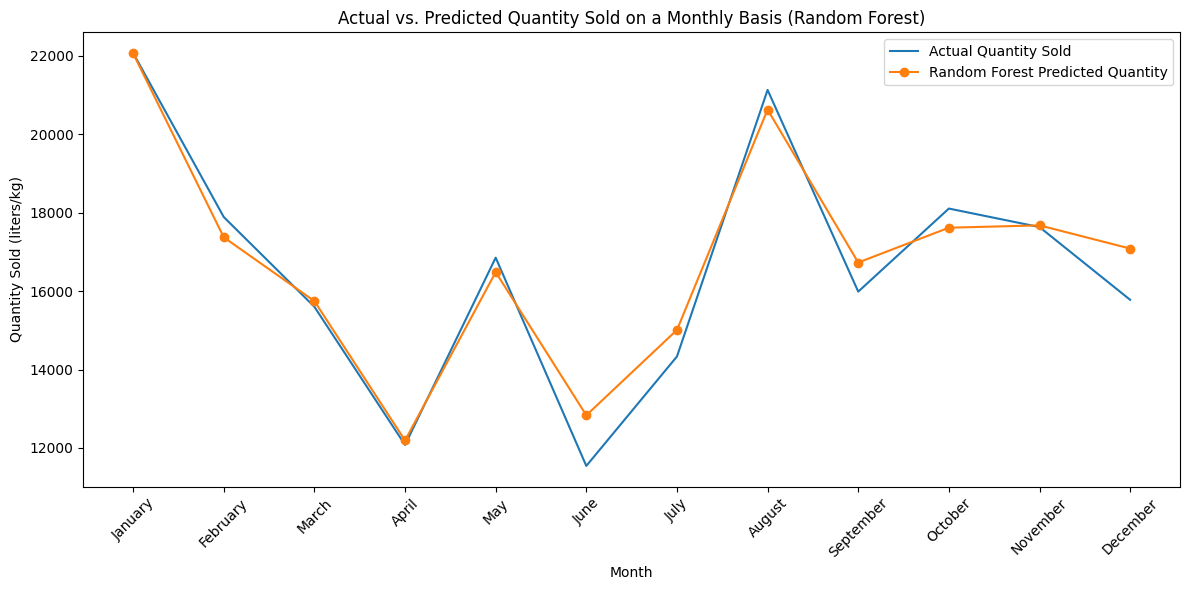

In [54]:
plt.figure(figsize=(12, 6))

plt.plot(monthly_actual_pd["Month"], monthly_actual_pd["Actual Quantity"], label='Actual Quantity Sold')
plt.plot(rf_reg_monthly_pd["Month"], rf_reg_monthly_pd["Predicted Quantity"], marker='o', label='Random Forest Predicted Quantity')

plt.xlabel('Month')
plt.ylabel('Quantity Sold (liters/kg)')
plt.title('Actual vs. Predicted Quantity Sold on a Monthly Basis (Random Forest)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Actual vs. Predicted Quantity Sold on a Monthly Basis (Gradient Boosted Tree)

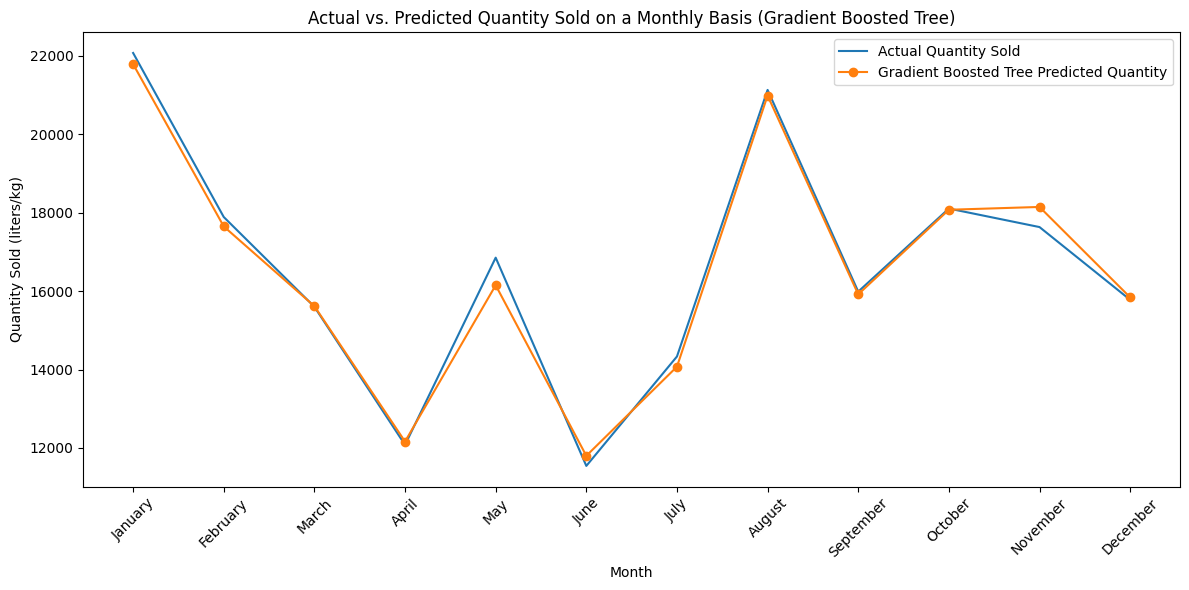

In [55]:
plt.figure(figsize=(12, 6))

plt.plot(monthly_actual_pd["Month"], monthly_actual_pd["Actual Quantity"], label='Actual Quantity Sold')
plt.plot(gbt_reg_monthly_pd["Month"], gbt_reg_monthly_pd["Predicted Quantity"], marker='o', label='Gradient Boosted Tree Predicted Quantity')

plt.xlabel('Month')
plt.ylabel('Quantity Sold (liters/kg)')
plt.title('Actual vs. Predicted Quantity Sold on a Monthly Basis (Gradient Boosted Tree)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()